In [42]:
import torch
import numpy as np
import os
import cma
from eval import play
from gan.config import SmallModelConfig
from gan.small_models import Generator
from gan.utils import tensor_to_level_str,check_playable
from gan.level_visualizer import LevelVisualizer
from play_rl.env import Env
from play_rl.wrappers import GridGame
from play_rl.policy import Policy
from PIL import Image

In [43]:
config = SmallModelConfig()
config.set_env()
config.cuda = False
if config.cuda:
    device = torch.device(
        "cuda" if torch.cuda.is_available else "cpu")
    print("device : cuda")
else:
    device = torch.device("cpu")
    print("device : cpu")
generator = Generator(
    out_dim=config.input_shape[0],
    shapes=config.model_shapes,
    z_shape=(config.latent_size,),
    filters=config.generator_filters,
).to(device)
env_def = Env(config.env_name,config.env_version)
level_visualizer = LevelVisualizer(env=env_def)

model_path = os.path.join(
    "/root/mnt/GVGAI-GAN/gan/checkpoints/none-866", "models_1160.tar")
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
x = torch.randn(config.latent_size).to(device)


device : cpu


Connecting to host 127.0.0.1 at port 41465 ...
Client connected to server [OK]
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=890334, Tue Aug 30 03:02:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 2.85e-01  3e-01  3e-01 0:00.1
INIT:  [ 1.76693094  1.56907833 -0.09770636 -0.60251617  1.22003567 -1.61887372
  2.13235021 -0.26763019 -0.00707452 -2.29846072  0.50046474  0.42246124
  0.20982257  1.71643341  0.68626428 -1.01465297  0.33398569  0.27124712
  0.62921721 -0.91158217  0.28969544  0.85712343 -3.27496219  0.57202262
 -0.7486257  -0.60968941 -1.60721123  0.04887146  0.02952653  0.65818495
  0.93487525 -2.98538017]
BEST:  [ 1.44754368  1.00806698  0.27181329 -1.09996415  0.87078837 -1.89453099
  2.04913945 -0.26010718  0.20248001 -1.76968901  0.40007131 -0.08521532
  0.18229152  1.68923916  1.02807517 -0.992192    0.23667346  0.30202551
  0.44369644 -0.62675933 -0.27007579  0.86434676 -3.51025704

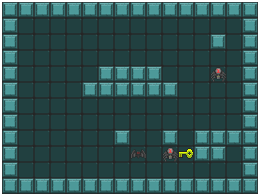

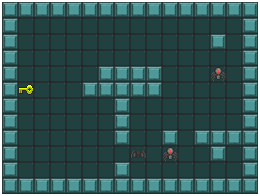

In [44]:
def eval(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return wall + enemy*10


env = GridGame(config.env_name, 200, env_def.state_shape)
actor = Policy(env.observation_space.shape, env.action_space)
actor.load_state_dict(torch.load('/root/mnt/GVGAI-GAN/play_rl/checkpoints/ppo/zelda_20220825102126.pt'))

def fitness(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1, 1, 1)
    level = generator(latent)
    level_str = tensor_to_level_str('zelda', level)
    playable = check_playable(level_str[0])
    if not playable:
        return 100
    reward,step = play(level_str[0],env=env,actor=actor)
    return -(reward*100+step)
    # ev = eval(level_str)
    # return -ev

def show(x):
    p_level = torch.nn.Softmax2d()(generator(x))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img = np.array(level_visualizer.draw_level(level_strs[0]))
    image = Image.fromarray(p_level_img)
    image.show()

es = cma.CMAEvolutionStrategy(x.tolist(), 0.3)
es.optimize(fitness)
best = np.array(es.best.get()[0])
print("INIT: ", np.array(x.tolist()))
print("BEST: ", best)
print("Fitness: ", fitness(best))

show(x)
show(torch.FloatTensor(best))
